# JAL-AM

In [1]:
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit, prange
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from model_lib import *
from JAL_AM_lib import *

In [4]:
k = np.linspace(0,1,7)
a, b, c = JAL_AM(0.3, 0.95, 500000, k)

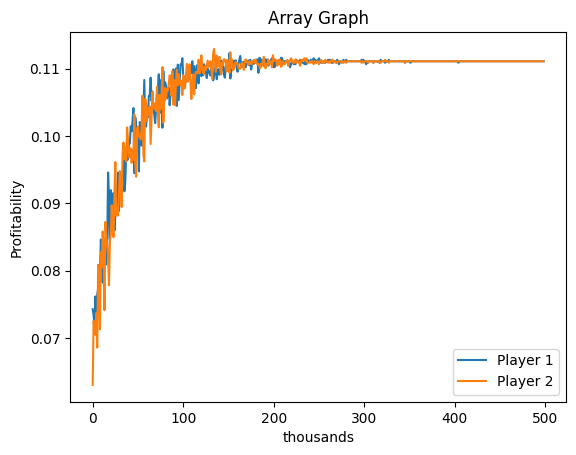

In [5]:
x_values = range(len(b))

# Plot the array as a line graph
plt.plot(x_values, b)
plt.plot(x_values, c)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

In [6]:
print(a[0, 490000:490010])

[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333 0.33333333
 0.33333333 0.33333333 0.33333333 0.33333333]


In [7]:
avg_prof,prof_gain,n= run_sim(100, np.linspace(0,1,13))

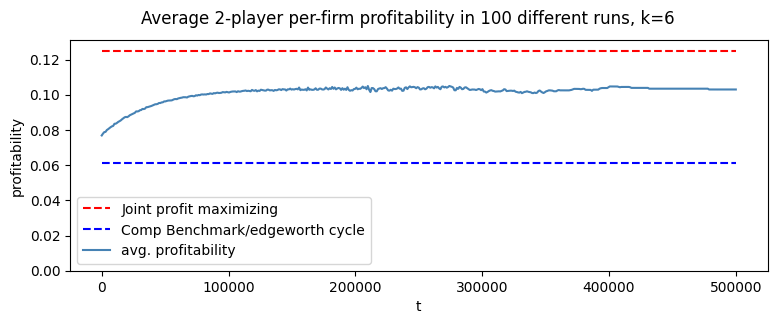

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(n, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
axs.plot(xs, avg_prof, color="steelblue", label = "avg. profitability")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [10]:
avg_prof[498]

0.10200042087542084

0.09415772306397278

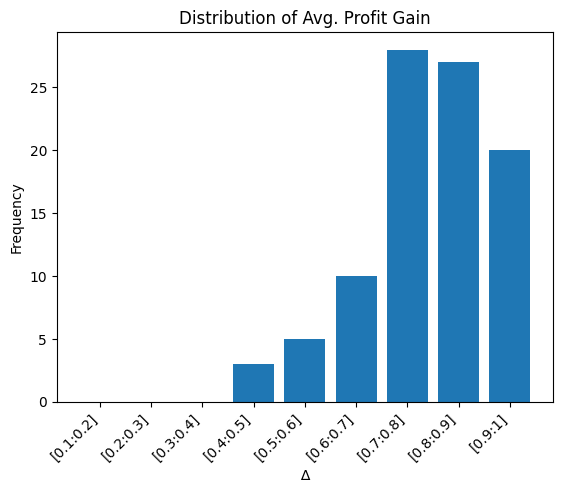

In [11]:
# Define the intervals
intervals = [(0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1)]
intervals_str = ['[0.1:0.2]','[0.2:0.3]', '[0.3:0.4]', '[0.4:0.5]', '[0.5:0.6]', '[0.6:0.7]', '[0.7:0.8]', '[0.8:0.9]', '[0.9:1]']

# Initialize an array to store counts for each interval
interval_counts = np.zeros(len(intervals), dtype=int)

# Iterate through the array and count values in each interval
for num in prof_gain:
    for i, interval in enumerate(intervals):
        if interval[0] <= num < interval[1]:
            interval_counts[i] += 1

# Plot the counts for each interval
plt.bar(np.arange(len(intervals)), interval_counts, tick_label=intervals_str)
plt.xticks(rotation=45, ha='right')
plt.xlabel('∆')
plt.ylabel('Frequency')
plt.title('Distribution of Avg. Profit Gain')
plt.show()

# Assymetric

In [2]:
res_asym, avg_prof_gain_asym,t_asym= run_sim_Asym(100, np.linspace(0,1,7),0.5)

In [3]:
res, avg_prof_gain,t= run_sim(100, np.linspace(0,1,7))

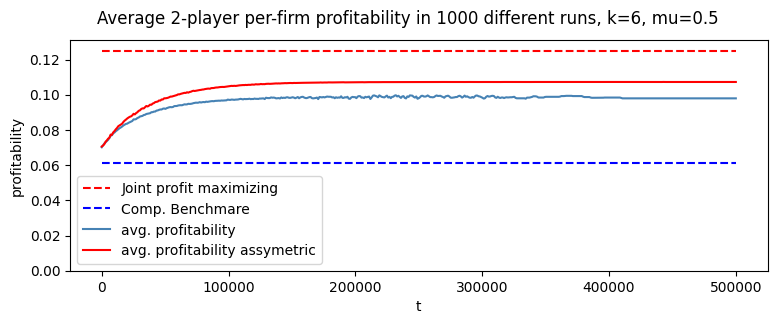

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}, mu={}".format(1000,6, 0.5))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp. Benchmare')#konstant taget fra johanne og morten
axs.plot(xs,res,color="steelblue", label ="avg. profitability")
axs.plot(xs, res_asym, color="red", label = "avg. profitability assymetric")

axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [96]:
@njit
def select_price(s_t_idx, price_grid, epsilon, AV):
    if epsilon >= np.random.uniform(0, 1):
        return np.random.choice(price_grid)
    else:
        maxedQ_idx = np.argmax(AV[s_t_idx, :])
        return price_grid[maxedQ_idx]


In [97]:
from tqdm.notebook import tqdm
from tqdm import tqdm
@njit
def update_AV(AV, s, Q, pi_other, action_space):
    """
    Args:
        AV: The action-value matrix to update
        s: The current state
        Q: The Q-value table
        pi_other: The estimated policy of the other agents
        action_space: The action space for the other agents
    """
    for a_i in range(len(action_space)):
        expected_value = 0.0  # Ensure expected_value is a scalar
        for a_j in range(len(action_space)):  # Iterate over actions of the other agent
            joint_action = (a_i, a_j)
            prob = pi_other[s, a_j]
            expected_value += Q[s, joint_action[0], joint_action[1]] * prob  # Handle joint_action indexing correctly
        AV[s, a_i] = expected_value
    return AV
@njit
def Q_func(p_curr_idx, s_curr_idx, i, j, t, alpha, gamma, p_table, Q_table, price_grid, s_next, pi_other, T, AV):
    prev_est = Q_table[s_curr_idx, p_curr_idx]
    s_next_index = np.where(price_grid == s_next)[0][0]
    Max_AV_idx = np.argmax(AV[s_next_index, :])
    Max_AV = AV[s_next_index, Max_AV_idx]
    reward = profit(p_table[i, t], p_table[j, t-2]) + gamma * profit(p_table[i, t], s_next) + gamma**2 * Max_AV
    return (1 - alpha) * prev_est + alpha * reward
@njit
def JAL_AM(alpha, gamma, T, price_grid):
    epsilon = calculate_epsilon(T)
    i, j = 0, 1
    t = 0
    k = len(price_grid)
    q1, q2 = np.zeros((k, k, k)), np.zeros((k, k, k))  # Adjust dimensions to handle joint actions
    Agent_model_1, Agent_model_2 = np.ones((k, k)) / k, np.ones((k, k)) / k
    AV_1, AV_2 = np.ones((k, k)), np.ones((k, k))
    N1, N2 = np.zeros((k, k)), np.zeros((k, k))
    p_table = np.zeros((2, T))
    profits = np.zeros((2, T))
    avg_profs1, avg_profs2 = [], []

    p_table[i, t] = np.random.choice(price_grid)
    p_table[j, t] = np.random.choice(price_grid)
    t += 1
    p_table[i, t] = np.random.choice(price_grid)
    p_table[j, t] = np.random.choice(price_grid)
    t += 1
    
    for t in range(t, T):
        p_table[i, t] = p_table[i, t-1]
        p_idx = np.where(price_grid == p_table[i, t])[0][0]
        s_next = p_table[j, t-1]
        current_state_idx = np.where(price_grid == p_table[j, t-2])[0][0]
        
        N2, Agent_model_2 = update_agent_model(Agent_model_2, p_idx, current_state_idx, N2, k)
        AV_1 = update_AV(AV_1, current_state_idx, q1, Agent_model_2, price_grid)
        q1[current_state_idx, p_idx] = Q_func(p_idx, current_state_idx, i, j, t, alpha, gamma, p_table, q1, price_grid, s_next, Agent_model_2, T, AV_1)
        
        s_next_idx = np.where(price_grid == p_table[j, t-1])[0][0]
        p_table[i, t] = select_price(s_next_idx, price_grid, epsilon[t], AV_1)
        p_table[j, t] = p_table[j, t-1]
        
        profits[i, t] = profit(p_table[i, t], p_table[j, t])
        profits[j, t] = profit(p_table[j, t], p_table[i, t])
        
        if t % 1000 == 0:
            avg_profs1.append(np.sum(profits[i, (t-1000):t]) / 1000)
            avg_profs2.append(np.sum(profits[j, (t-1000):t]) / 1000)
        
        i, j = j, i
        q1, q2 = q2, q1
        Agent_model_1, Agent_model_2 = Agent_model_2, Agent_model_1
        N1, N2 = N2, N1
        AV_1, AV_2 = AV_2, AV_1
    
    return p_table, avg_profs1, avg_profs2

def run_sim(n, k):
    """
    args:
        n: number of runs simulated
        k: length of price action vector
    returns:
        avg_avg_profitabilities: average of average profits over n simulations
    """
    num_calcs=int(500000/1000-1) # size of avg. profits 
    summed_avg_profitabilities = np.zeros(num_calcs)
    avg_prof_gain = np.zeros((n))
    t=n
    # simulating n runs of JAL-AM
    for i in tqdm(range(n), desc='WoLF-PHC 3/3', leave=True):
        p_table, avg_profs1, avg_profs2 = JAL_AM(0.3, 0.95, 500000, k)
        per_firm_profit = np.sum([avg_profs1, avg_profs2], axis=0)/2
        avg_prof_gain[i] = per_firm_profit[498]/0.125
        summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)

    avg_avg_profitabilities = np.divide(summed_avg_profitabilities, n)
    return avg_avg_profitabilities, avg_prof_gain, t


In [90]:
k = np.linspace(0,1,7)
a, b, c = JAL_AM(0.3, 0.95, 500000, k)

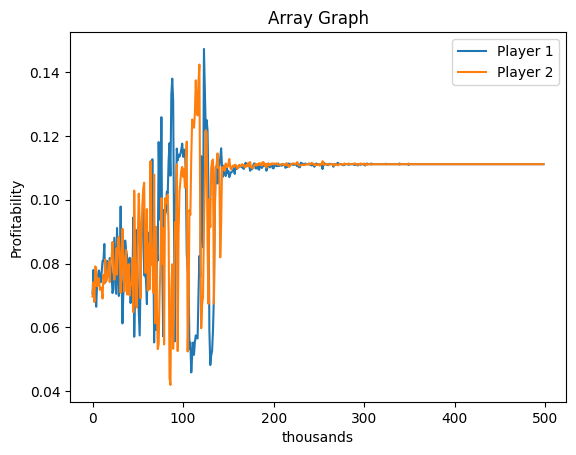

In [91]:
x_values = range(len(b))

# Plot the array as a line graph
plt.plot(x_values, b)
plt.plot(x_values, c)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

In [103]:
avg_prof,prof_gain,n= run_sim(100, np.linspace(0,1,7))

WoLF-PHC 3/3:   0%|          | 0/100 [00:00<?, ?it/s]

WoLF-PHC 3/3: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]


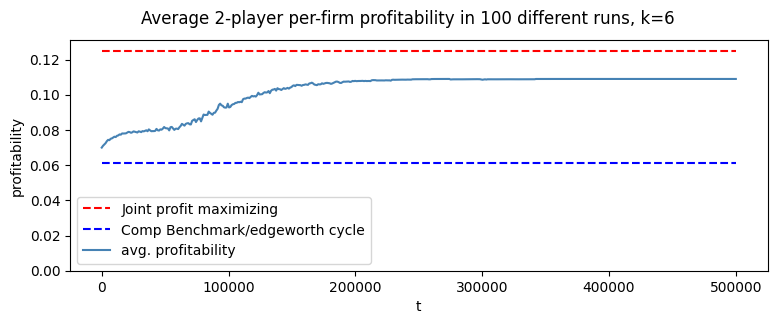

In [99]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(n, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
axs.plot(xs, avg_prof, color="steelblue", label = "avg. profitability")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()

In [100]:
avg_prof[498]

0.10895694444444536

# Asym


In [115]:
@njit
def select_price_asym(true_state, price_grid, epsilon, AV, mu):
    if mu<=np.random.uniform(0,1):
        s_t_idx=true_state 
    else:
        s_t_idx=np.where(price_grid==np.random.choice(price_grid))[0][0]
    
    if epsilon >= np.random.uniform(0, 1):
        return np.random.choice(price_grid)
    else:
        maxedQ_idx = np.argmax(AV[s_t_idx, :])
        return price_grid[maxedQ_idx]

@njit
def JAL_AM_asym(alpha, gamma, T, price_grid,mu):
    epsilon = calculate_epsilon(T)
    i, j = 0, 1
    t = 0
    k = len(price_grid)
    q1, q2 = np.zeros((k, k, k)), np.zeros((k, k, k))  # Adjust dimensions to handle joint actions
    Agent_model_1, Agent_model_2 = np.ones((k, k)) / k, np.ones((k, k)) / k
    AV_1, AV_2 = np.ones((k, k)), np.ones((k, k))
    N1, N2 = np.zeros((k, k)), np.zeros((k, k))
    p_table = np.zeros((2, T))
    profits = np.zeros((2, T))
    avg_profs1, avg_profs2 = [], []

    p_table[i, t] = np.random.choice(price_grid)
    p_table[j, t] = np.random.choice(price_grid)
    t += 1
    p_table[i, t] = np.random.choice(price_grid)
    p_table[j, t] = np.random.choice(price_grid)
    t += 1
    
    for t in range(t, T):
        if t%2!=0:
            p_table[i, t] = p_table[i, t-1]
            p_idx = np.where(price_grid == p_table[i, t])[0][0]
            s_next = p_table[j, t-1]
            current_state_idx = np.where(price_grid == p_table[j, t-2])[0][0]
            
            N2, Agent_model_2 = update_agent_model(Agent_model_2, p_idx, current_state_idx, N2, k)
            AV_1 = update_AV(AV_1, current_state_idx, q1, Agent_model_2, price_grid)
            q1[current_state_idx, p_idx] = Q_func(p_idx, current_state_idx, i, j, t, alpha, gamma, p_table, q1, price_grid, s_next, Agent_model_2, T, AV_1)
            
            s_next_idx = np.where(price_grid == p_table[j, t-1])[0][0]
            p_table[i, t] = select_price(s_next_idx, price_grid, epsilon[t], AV_1)
            p_table[j, t] = p_table[j, t-1]
            
            profits[i, t] = profit(p_table[i, t], p_table[j, t])
            profits[j, t] = profit(p_table[j, t], p_table[i, t])
        else:
            p_table[j, t] = p_table[j, t-1]
            p_idx = np.where(price_grid == p_table[j, t])[0][0]
            s_next = p_table[i, t-1]
            current_state_idx = np.where(price_grid == p_table[i, t-2])[0][0]
            
            N1, Agent_model_1 = update_agent_model(Agent_model_1, p_idx, current_state_idx, N1, k)
            AV_2 = update_AV(AV_2, current_state_idx, q2, Agent_model_1, price_grid)
            q1[current_state_idx, p_idx] = Q_func(p_idx, current_state_idx, j, i, t, alpha, gamma, p_table, q2, price_grid, s_next, Agent_model_1, T, AV_2)
            
            s_next_idx = np.where(price_grid == p_table[i, t-1])[0][0]
            p_table[j, t] = select_price_asym(s_next_idx, price_grid, epsilon[t], AV_2, mu)
            p_table[i, t] = p_table[i, t-1]
        
                 
            profits[i, t] = profit(p_table[i, t], p_table[j, t])
            profits[j, t] = profit(p_table[j, t], p_table[i, t])
            
        if t % 1000 == 0:
            avg_profs1.append(np.sum(profits[i, (t-1000):t]) / 1000)
            avg_profs2.append(np.sum(profits[j, (t-1000):t]) / 1000)
        
        
    
    return p_table, avg_profs1, avg_profs2

def run_sim_asym(n, k,mu):
    """
    args:
        n: number of runs simulated
        k: length of price action vector
    returns:
        avg_avg_profitabilities: average of average profits over n simulations
    """
    num_calcs=int(500000/1000-1) # size of avg. profits 
    summed_avg_profitabilities = np.zeros(num_calcs)
    avg_prof_gain = np.zeros((n))
    t=n
    # simulating n runs of JAL-AM
    for i in tqdm(range(n), desc='WoLF-PHC 3/3', leave=True):
        p_table, avg_profs1, avg_profs2 = JAL_AM_asym(0.3, 0.95, 500000, k,mu)
        per_firm_profit = np.sum([avg_profs1, avg_profs2], axis=0)/2
        avg_prof_gain[i] = per_firm_profit[498]/0.125
        summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)

    avg_avg_profitabilities = np.divide(summed_avg_profitabilities, n)
    return avg_avg_profitabilities, avg_prof_gain, t

In [118]:
@njit
def select_price_asym(true_state, price_grid, epsilon, AV, mu):
    if mu <= np.random.uniform(0, 1):
        s_t_idx = true_state 
    else:
        s_t_idx = np.random.randint(len(price_grid))
    
    if epsilon >= np.random.uniform(0, 1):
        return np.random.choice(price_grid)
    else:
        maxedQ_idx = np.argmax(AV[s_t_idx, :])
        return price_grid[maxedQ_idx]
@njit
def JAL_AM_asym(alpha, gamma, T, price_grid, mu):
    epsilon = calculate_epsilon(T)
    i, j = 0, 1
    t = 0
    k = len(price_grid)
    q1, q2 = np.zeros((k, k, k)), np.zeros((k, k, k))  # Adjust dimensions to handle joint actions
    Agent_model_1, Agent_model_2 = np.ones((k, k)) / k, np.ones((k, k)) / k
    AV_1, AV_2 = np.ones((k, k)), np.ones((k, k))
    N1, N2 = np.zeros((k, k)), np.zeros((k, k))
    p_table = np.zeros((2, T))
    profits = np.zeros((2, T))
    avg_profs1, avg_profs2 = [], []

    p_table[i, t] = np.random.choice(price_grid)
    p_table[j, t] = np.random.choice(price_grid)
    t += 1
    p_table[i, t] = np.random.choice(price_grid)
    p_table[j, t] = np.random.choice(price_grid)
    t += 1
    
    for t in range(t, T):
        if t % 2 != 0:
            p_table[i, t] = p_table[i, t-1]
            p_idx = np.where(price_grid == p_table[i, t])[0][0]
            s_next = p_table[j, t-1]
            current_state_idx = np.where(price_grid == p_table[j, t-2])[0][0]
            
            N2, Agent_model_2 = update_agent_model(Agent_model_2, p_idx, current_state_idx, N2, k)
            AV_1 = update_AV(AV_1, current_state_idx, q1, Agent_model_2, price_grid)
            q1[current_state_idx, p_idx] = Q_func(p_idx, current_state_idx, i, j, t, alpha, gamma, p_table, q1, price_grid, s_next, Agent_model_2, T, AV_1)
            
            s_next_idx = np.where(price_grid == p_table[j, t-1])[0][0]
            p_table[i, t] = select_price_asym(s_next_idx, price_grid, epsilon[t], AV_1, mu)
            p_table[j, t] = p_table[j, t-1]
            
            profits[i, t] = profit(p_table[i, t], p_table[j, t])
            profits[j, t] = profit(p_table[j, t], p_table[i, t])
        else:
            p_table[j, t] = p_table[j, t-1]
            p_idx = np.where(price_grid == p_table[j, t])[0][0]
            s_next = p_table[i, t-1]
            current_state_idx = np.where(price_grid == p_table[i, t-2])[0][0]
            
            N1, Agent_model_1 = update_agent_model(Agent_model_1, p_idx, current_state_idx, N1, k)
            AV_2 = update_AV(AV_2, current_state_idx, q2, Agent_model_1, price_grid)
            q2[current_state_idx, p_idx] = Q_func(p_idx, current_state_idx, j, i, t, alpha, gamma, p_table, q2, price_grid, s_next, Agent_model_1, T, AV_2)
            
            s_next_idx = np.where(price_grid == p_table[i, t-1])[0][0]
            p_table[j, t] = select_price_asym(s_next_idx, price_grid, epsilon[t], AV_2, mu)
            p_table[i, t] = p_table[i, t-1]
            
            profits[i, t] = profit(p_table[i, t], p_table[j, t])
            profits[j, t] = profit(p_table[j, t], p_table[i, t])
            
        if t % 1000 == 0:
            avg_profs1.append(np.sum(profits[i, (t-1000):t]) / 1000)
            avg_profs2.append(np.sum(profits[j, (t-1000):t]) / 1000)
    
    return p_table, avg_profs1, avg_profs2
def run_sim_asym(n, k, mu):
    """
    args:
        n: number of runs simulated
        k: length of price action vector
    returns:
        avg_avg_profitabilities: average of average profits over n simulations
    """
    num_calcs = int(500000 / 1000 - 1)  # size of avg. profits 
    summed_avg_profitabilities = np.zeros(num_calcs)
    avg_prof_gain = np.zeros((n))
    t = n
    
    # simulating n runs of JAL-AM
    for i in tqdm(range(n), desc='WoLF-PHC 3/3', leave=True):
        p_table, avg_profs1, avg_profs2 = JAL_AM_asym(0.3, 0.95, 500000, k, mu)
        per_firm_profit = np.sum([avg_profs1, avg_profs2], axis=0) / 2
        avg_prof_gain[i] = per_firm_profit[-1] / 0.125  # Adjust index to access the last element correctly
        summed_avg_profitabilities = np.sum([summed_avg_profitabilities, per_firm_profit], axis=0)
    
    avg_avg_profitabilities = np.divide(summed_avg_profitabilities, n)
    return avg_avg_profitabilities, avg_prof_gain, t


In [123]:
avg_prof_asym,prof_gain,n= run_sim_asym(1000, np.linspace(0,1,7),0.05)

WoLF-PHC 3/3: 100%|██████████| 1000/1000 [05:22<00:00,  3.10it/s]


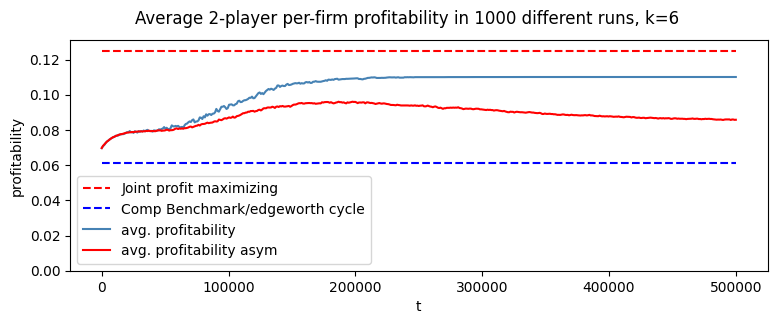

In [124]:
fig, axs = plt.subplots(1, 1, figsize=(9,3))
fig.suptitle("Average 2-player per-firm profitability in {} different runs, k={}".format(n, 6))
axs.set_xlabel("t")
axs.set_ylabel("profitability")
xs = np.linspace(0, 500000, 499)
axs.set_ylim(0.00, 0.125+(0.125*0.05))
axs.hlines(0.125, xmin=xs[0], xmax=xs[-1], colors='red', linestyles='dashed', label='Joint profit maximizing')
axs.hlines(0.0611, xmin=xs[0], xmax=xs[-1], colors='blue', linestyles='dashed', label='Comp Benchmark/edgeworth cycle')#konstant taget fra johanne og morten
axs.plot(xs, avg_prof, color="steelblue", label = "avg. profitability")
axs.plot(xs, avg_prof_asym, color="red", label = "avg. profitability asym")
axs.legend()  # Show the legend to display the label of the newly added line
plt.show()